In [1]:
rm *.json TSL*.csv

# 1. Stock data scraper

In [106]:
import urllib.request, json , time, os, difflib, itertools
import pandas as pd
import numpy as np
from datetime import datetime
import http.client as httplib
import matplotlib.pyplot as plt
import mplfinance as mpf
import csv
import seaborn as sb
from finta import TA

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from xgboost import XGBClassifier

from keras.layers import Dense, LSTM, Input, Dropout, Embedding, Bidirectional
from keras.utils import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.firefox.options import Options

import re
from wordcloud import WordCloud
from stop_words import get_stop_words

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# можно переделать сбор с yahoo через yfinance

In [4]:
def check_internet():
    conn = httplib.HTTPConnection("www.google.com", timeout=5)
    try:
        conn.request("HEAD", "/")
        conn.close()
        return True
    except:
        conn.close()
        return False

In [5]:
def stock_init():
    json_path = ""
    csv_path = ""
        
    ticker = "TSLA"
    
    csv_file = ticker + '.csv'

    period2 = str(round(datetime.now().timestamp()))
    period1 = str(round(int(period2) - 3 * 3600 * 24 * 365))
    print(period2 + " || " + str(datetime.now().strftime('%y/%m/%d')))
    print(period1 + " || " + str(datetime.utcfromtimestamp(int(period1)).strftime('%d/%m/%y')))

    interval = "1d"

    query_urls = "https://query1.finance.yahoo.com/v8/finance/chart/"+ticker+"?symbol="+ticker+"&period1="+period1+"&period2="+period2+"&interval="+interval+"&includePrePost=true&events=div%2Csplit"
    
    return ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls

In [6]:
def get_frame(parsed):
    Date=[]
    for i in parsed['chart']['result'][0]['timestamp']:
#         Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d/%m/%y'))
        Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d/%m/%y'))

        Low=parsed['chart']['result'][0]['indicators']['quote'][0]['low']
        Open=parsed['chart']['result'][0]['indicators']['quote'][0]['open']
        Volume=parsed['chart']['result'][0]['indicators']['quote'][0]['volume']
        High=parsed['chart']['result'][0]['indicators']['quote'][0]['high']
        Close=parsed['chart']['result'][0]['indicators']['quote'][0]['close']
        Adjusted_Close=parsed['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']

        df=pd.DataFrame(list(zip(Date,Open,High,Low,Close, Adjusted_Close,Volume)),columns =['Date','Open','High','Low','Close','Adj Close','Volume'])
    
    return df

In [7]:
def get_historic_price(query_url,json_path,csv_path):
    
    stock_id=query_url.split("&period")[0].split("symbol=")[1]

    if os.path.exists(csv_path+stock_id+'.csv') and os.stat(csv_path+stock_id+'.csv').st_size != 0:
        print("<<<  Historical data of "+stock_id+" already exists")
        return
    
    while not check_internet():
        print("Could not connect, trying again in 5 seconds...")
        time.sleep(5)

    try:
        with urllib.request.urlopen(query_url) as url:
            parsed = json.loads(url.read().decode())
    
    except:
        print("|||  Historical data of "+stock_id+" doesn't exist")
        return
    
    else:
        if os.path.exists(json_path+stock_id+'.json') and os.stat(json_path+stock_id+'.json').st_size != 0:
            os.remove(json_path+stock_id+'.json')
        
        with open(json_path+stock_id+'.json', 'w') as outfile:
            json.dump(parsed, outfile, indent=4)
        
        try:
            df = get_frame(parsed)
            
            if os.path.exists(csv_path+stock_id+'.csv'):
                os.remove(csv_path+stock_id+'.csv')
            df.to_csv(csv_path+stock_id+'.csv', sep=',', index=None)
            
            print(">>>  Historical data of "+stock_id+" saved")
        
        except:
            print(">>>  Historical data of "+stock_id+" could not be saved")

In [8]:
def csv_draw(csv_file):

    frame = pd.read_csv(csv_file, index_col=0,parse_dates=True)
    frame.index.name = 'Date'
    
    mpf.plot(frame, type='candle', style = 'sas',  
             mav = (3,6,9),volume=True, figscale = 1,
             savefig = "TSLA_chart.png")
    
    

In [9]:
ticker, json_path, csv_path, csv_file, period1, period2, interval, query_urls = stock_init()

1672332152 || 22/12/29
1577724152 || 30/12/19


In [10]:
get_historic_price(query_urls, json_path, csv_path)

>>>  Historical data of TSLA saved


In [11]:
cp TSLA.csv TSLA2.csv

In [12]:
cp TSLA.csv TSLA3.csv

In [13]:
frame = pd.read_csv(ticker + '.csv', index_col=0)#,parse_dates=True)
frame.index.name = 'Date'
frame

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
31/12/19,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
02/01/20,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
03/01/20,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
06/01/20,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
...,...,...,...,...,...,...
21/12/22,139.339996,141.259995,135.889999,137.570007,137.570007,145417400
22/12/22,136.000000,136.630005,122.260002,125.349998,125.349998,210090300
23/12/22,126.370003,128.619995,121.019997,123.150002,123.150002,166396100


In [14]:
csv_draw(ticker + ".csv")

# 2. Data preprosessing

In [15]:
NUM_DAYS = 10000
INTERVAL = interval
symbol = ticker

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [16]:
df = pd.read_csv(ticker + '3.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
1,31/12/19,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
2,02/01/20,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
3,03/01/20,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
4,06/01/20,29.364668,30.104000,29.333332,30.102667,30.102667,151995000


In [17]:
df.shape

(756, 7)

In [18]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,206.350750,211.155990,200.978653,206.114887,206.114887,1.318108e+08
std,96.386356,98.401379,94.032963,96.199584,96.199584,1.000982e+08
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,138.633339,141.930000,135.544170,138.270828,138.270828,6.890498e+07
50%,223.964996,229.250000,218.174995,223.651665,223.651665,9.439035e+07
75%,278.281670,283.412506,270.410828,276.565002,276.565002,1.565354e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       756 non-null    object 
 1   Open       756 non-null    float64
 2   High       756 non-null    float64
 3   Low        756 non-null    float64
 4   Close      756 non-null    float64
 5   Adj Close  756 non-null    float64
 6   Volume     756 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.5+ KB


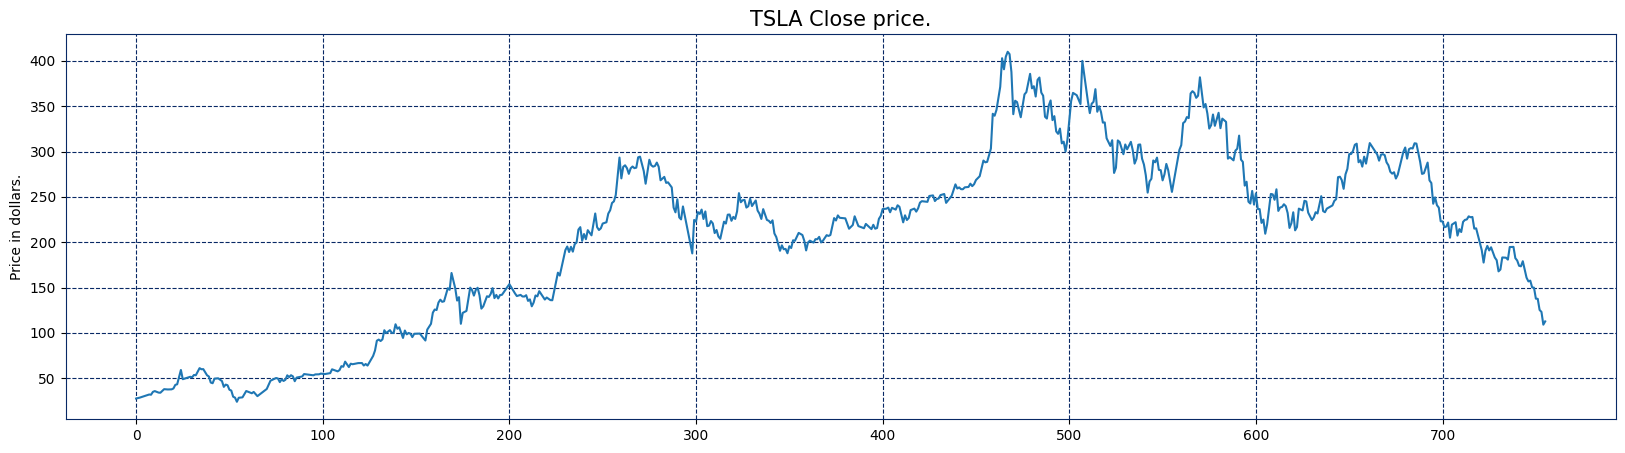

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(df['Close'])
plt.title('TSLA Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [21]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((756, 7), (756, 7))

In [22]:
df = df.drop(['Adj Close'], axis=1)

In [23]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

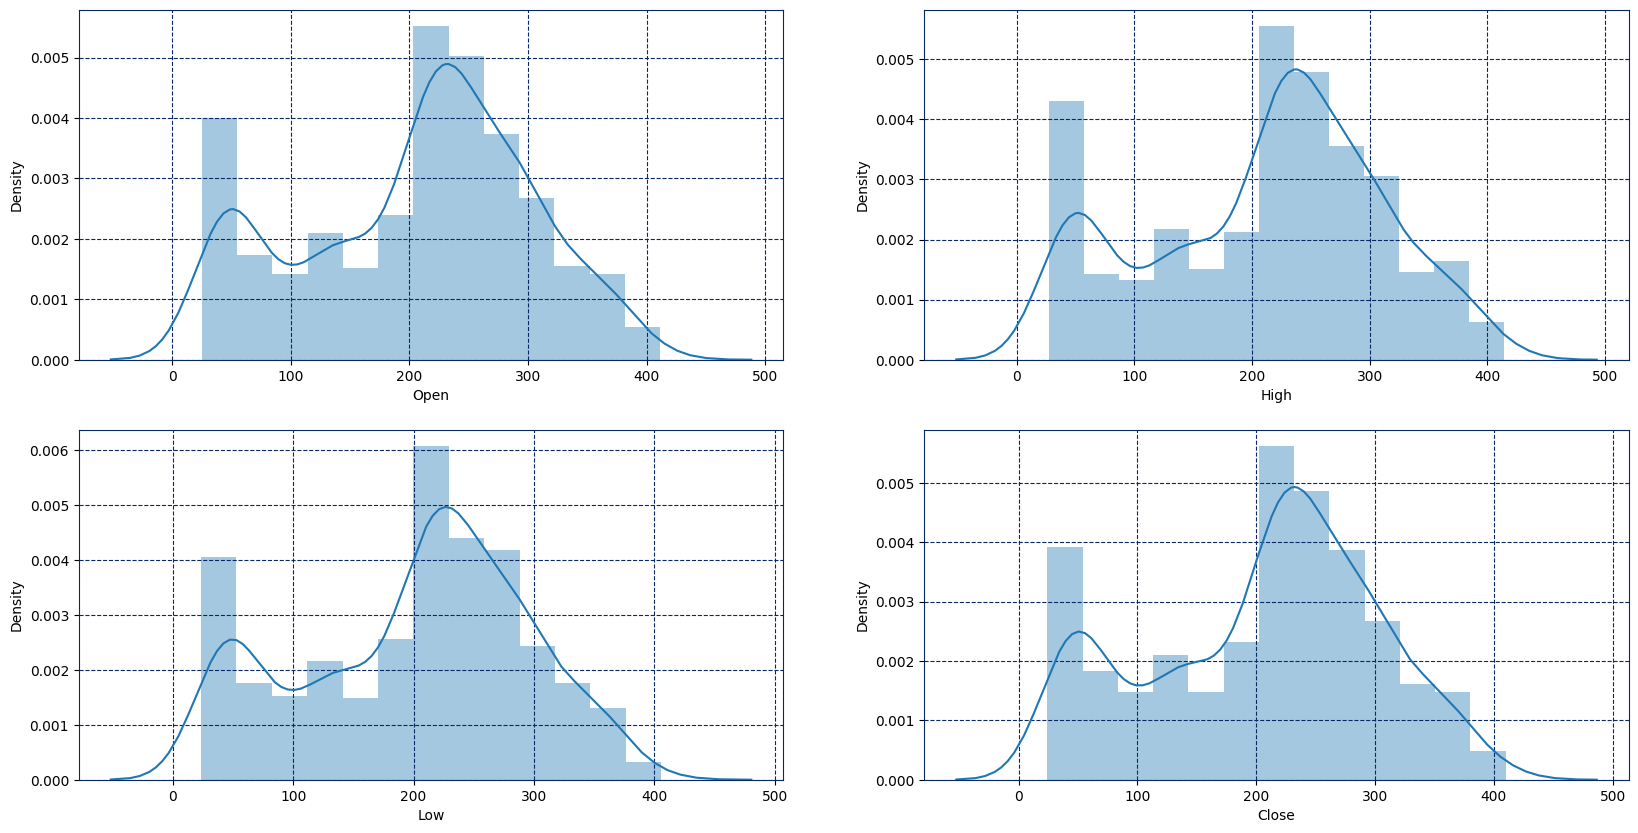

In [24]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sb.distplot(df[col])
plt.show()

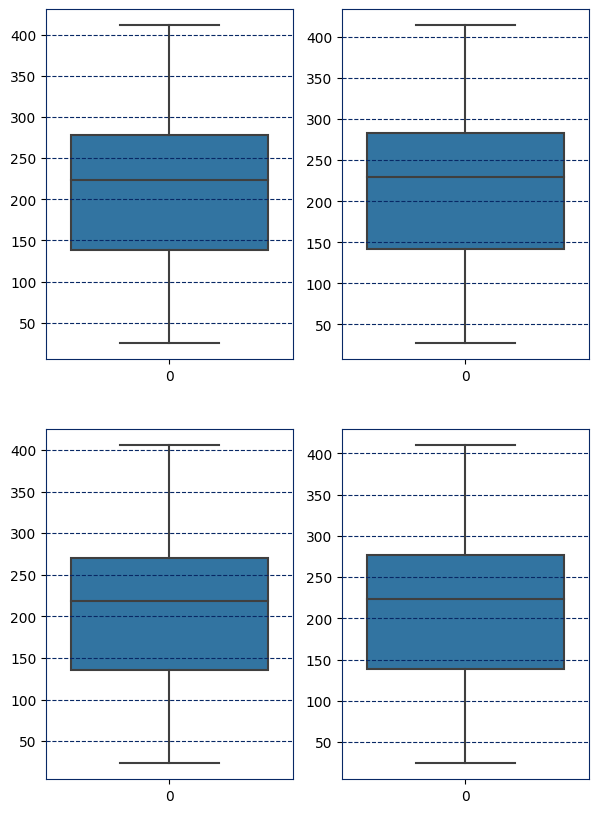

In [25]:
plt.subplots(figsize=(7,10))
for i, col in enumerate(features):
    plt.subplot(2,2,i+1)
    sb.boxplot(df[col])
plt.show()

In [26]:
splitted = df['Date'].str.split('/', expand=True)

df['day'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['year'] = splitted[2].astype('int')


df.head()

,Date,Open,High,Low,Close,Volume,day,month,year
0,30/12/19,28.586000,28.600000,27.284000,27.646667,188796000,30,12,19
1,31/12/19,27.000000,28.086000,26.805332,27.888666,154285500,31,12,19
2,02/01/20,28.299999,28.713333,28.114000,28.684000,142981500,2,1,20
3,03/01/20,29.366667,30.266666,29.128000,29.534000,266677500,3,1,20
4,06/01/20,29.364668,30.104000,29.333332,30.102667,151995000,6,1,20


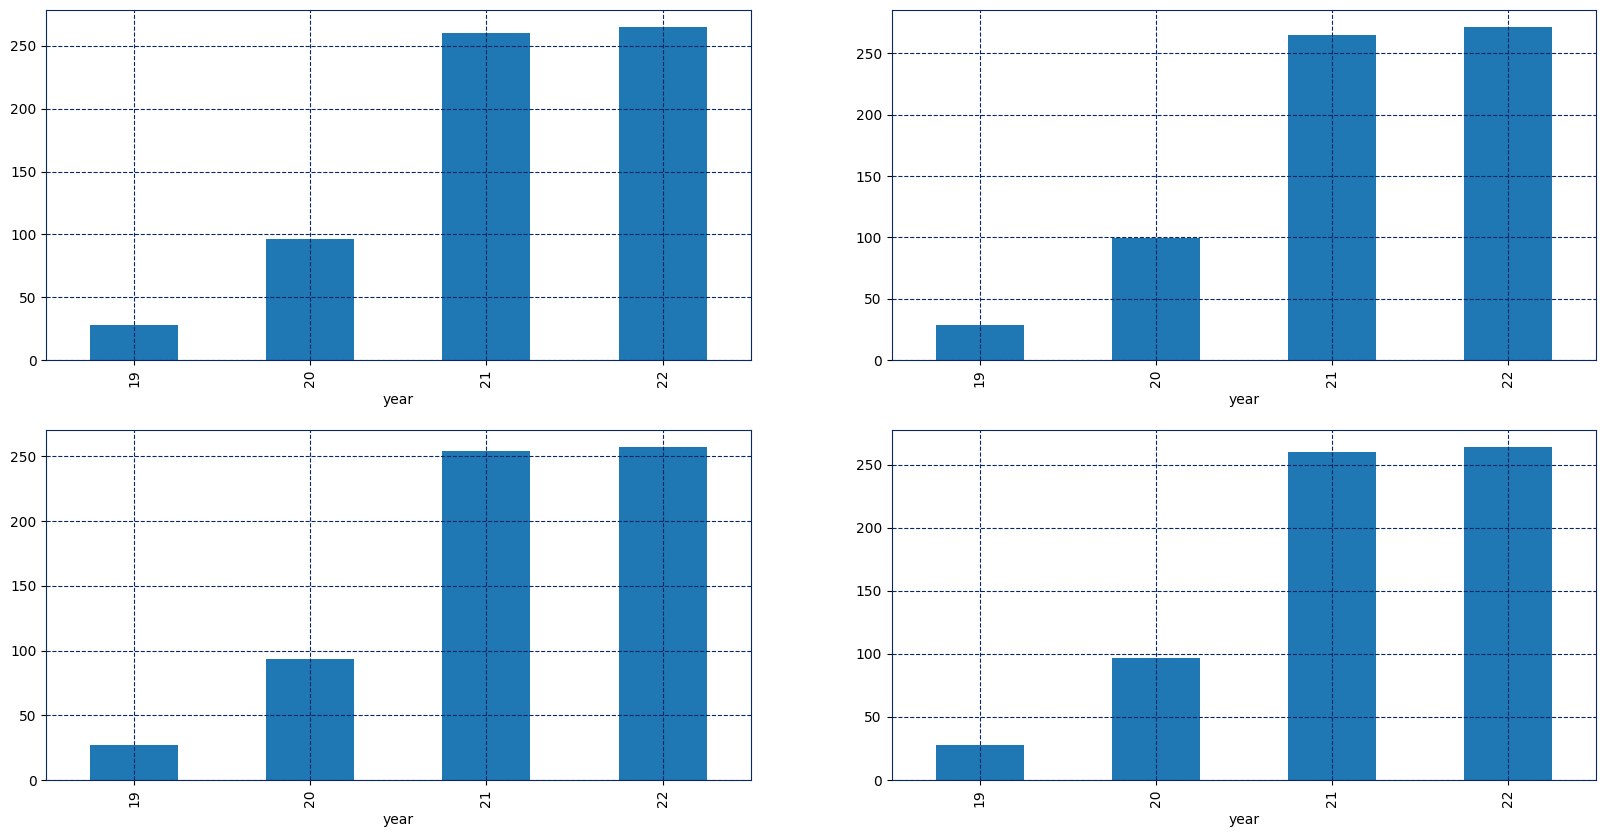

In [27]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
plt.show()

In [28]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# 3. News scraper

In [29]:
options = Options()
options.headless = True
options.page_load_strategy = 'eager'
options.set_preference('javascript.enabled', False)
options.set_preference("app.update.auto", False)
options.set_preference("app.update.enabled", False)

ticker = "TSLA"
period = "d"

total = 30

links = ["https://finviz.com"]

opt_links = ["https://finviz.com/quote.ashx?t="+ticker+"&p="+period]

In [30]:
browser = webdriver.Firefox(options=options)
browser.get(opt_links[0])

news_container = browser.find_element(By.CLASS_NAME, 'fullview-news-outer')
news = []
dates = []

for element in news_container.find_elements(By.TAG_NAME, 'a')[:total]:
    news.append(element.get_attribute('href'))

for element in news_container.find_elements(By.TAG_NAME, 'td')[:2 * total]:
    if element.get_attribute('align') == 'right':
        dates.append(element.text)
        
print('done')

browser.quit()

done


In [31]:
# dates

In [32]:
chars = ['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
         'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov']
news_dates = []
days_count = 0
for date in dates:
    if chars[0] in date:
        curr_date, _ = date.split(' ')
        news_dates.append(date)
        days_count += 1
#         print(curr_date)
    else:
        news_dates.append(curr_date + ' ' + date)

# del dates[0:total]

In [34]:
# news_dates

In [35]:
unique_sites = set()
for site in news: 
    buff = site.split('.')
    unique_sites.add(buff[1])
    
sites_dict = {}
count = 0

for a in unique_sites:
    for site in news:
        if a in site:
            count += 1
    sites_dict[a] = count
    count = 0
    
print(len(news))
print(unique_sites)
print(sites_dict)

30
{'yahoo'}
{'yahoo': 30}


In [36]:
articles = []
art = ""

for site in news[:total]:
    browser = webdriver.Firefox(options=options)
    browser.get(site)

    if 'yahoo' not in site:
        for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
                art += paragraph.text
    else:
        try:
            link = browser.find_element(By.XPATH, '/html/body/div[3]/div[1]/div/main/div[1]/div/div/div/div/article/div/div/div/div/div/div[2]/div[4]/div/a')
            href = link.get_attribute('href')
            browser.get(href)
            for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
                    art += paragraph.text
        except:
            b = browser.find_element(By.TAG_NAME, 'button')
            if b.text == 'Story continues':
                b.click()
            for paragraph in browser.find_elements(By.TAG_NAME, 'p'):
                    art += paragraph.text
            
    articles.append(art)
    art = ""
    
    browser.quit()
print("done")

done


In [37]:
for i in range(0, len(articles)):
    articles[i] = news_dates[i] + ' || ' + articles[i]

In [38]:
# articles[0]

In [39]:
STOPWORDS = get_stop_words('english')


def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis("off")

text = ''
    
for article in articles:
    if article != '':
        article = re.sub(r'==.*?==+', '', article)
        article = article.replace('\n', '')
    text += article
        
        
wordcloud = WordCloud(width = 2000, height = 1500, 
                      random_state=1, background_color='black', 
                      margin=20, colormap='Pastel1', collocations=False,
                      stopwords = STOPWORDS).generate(text)

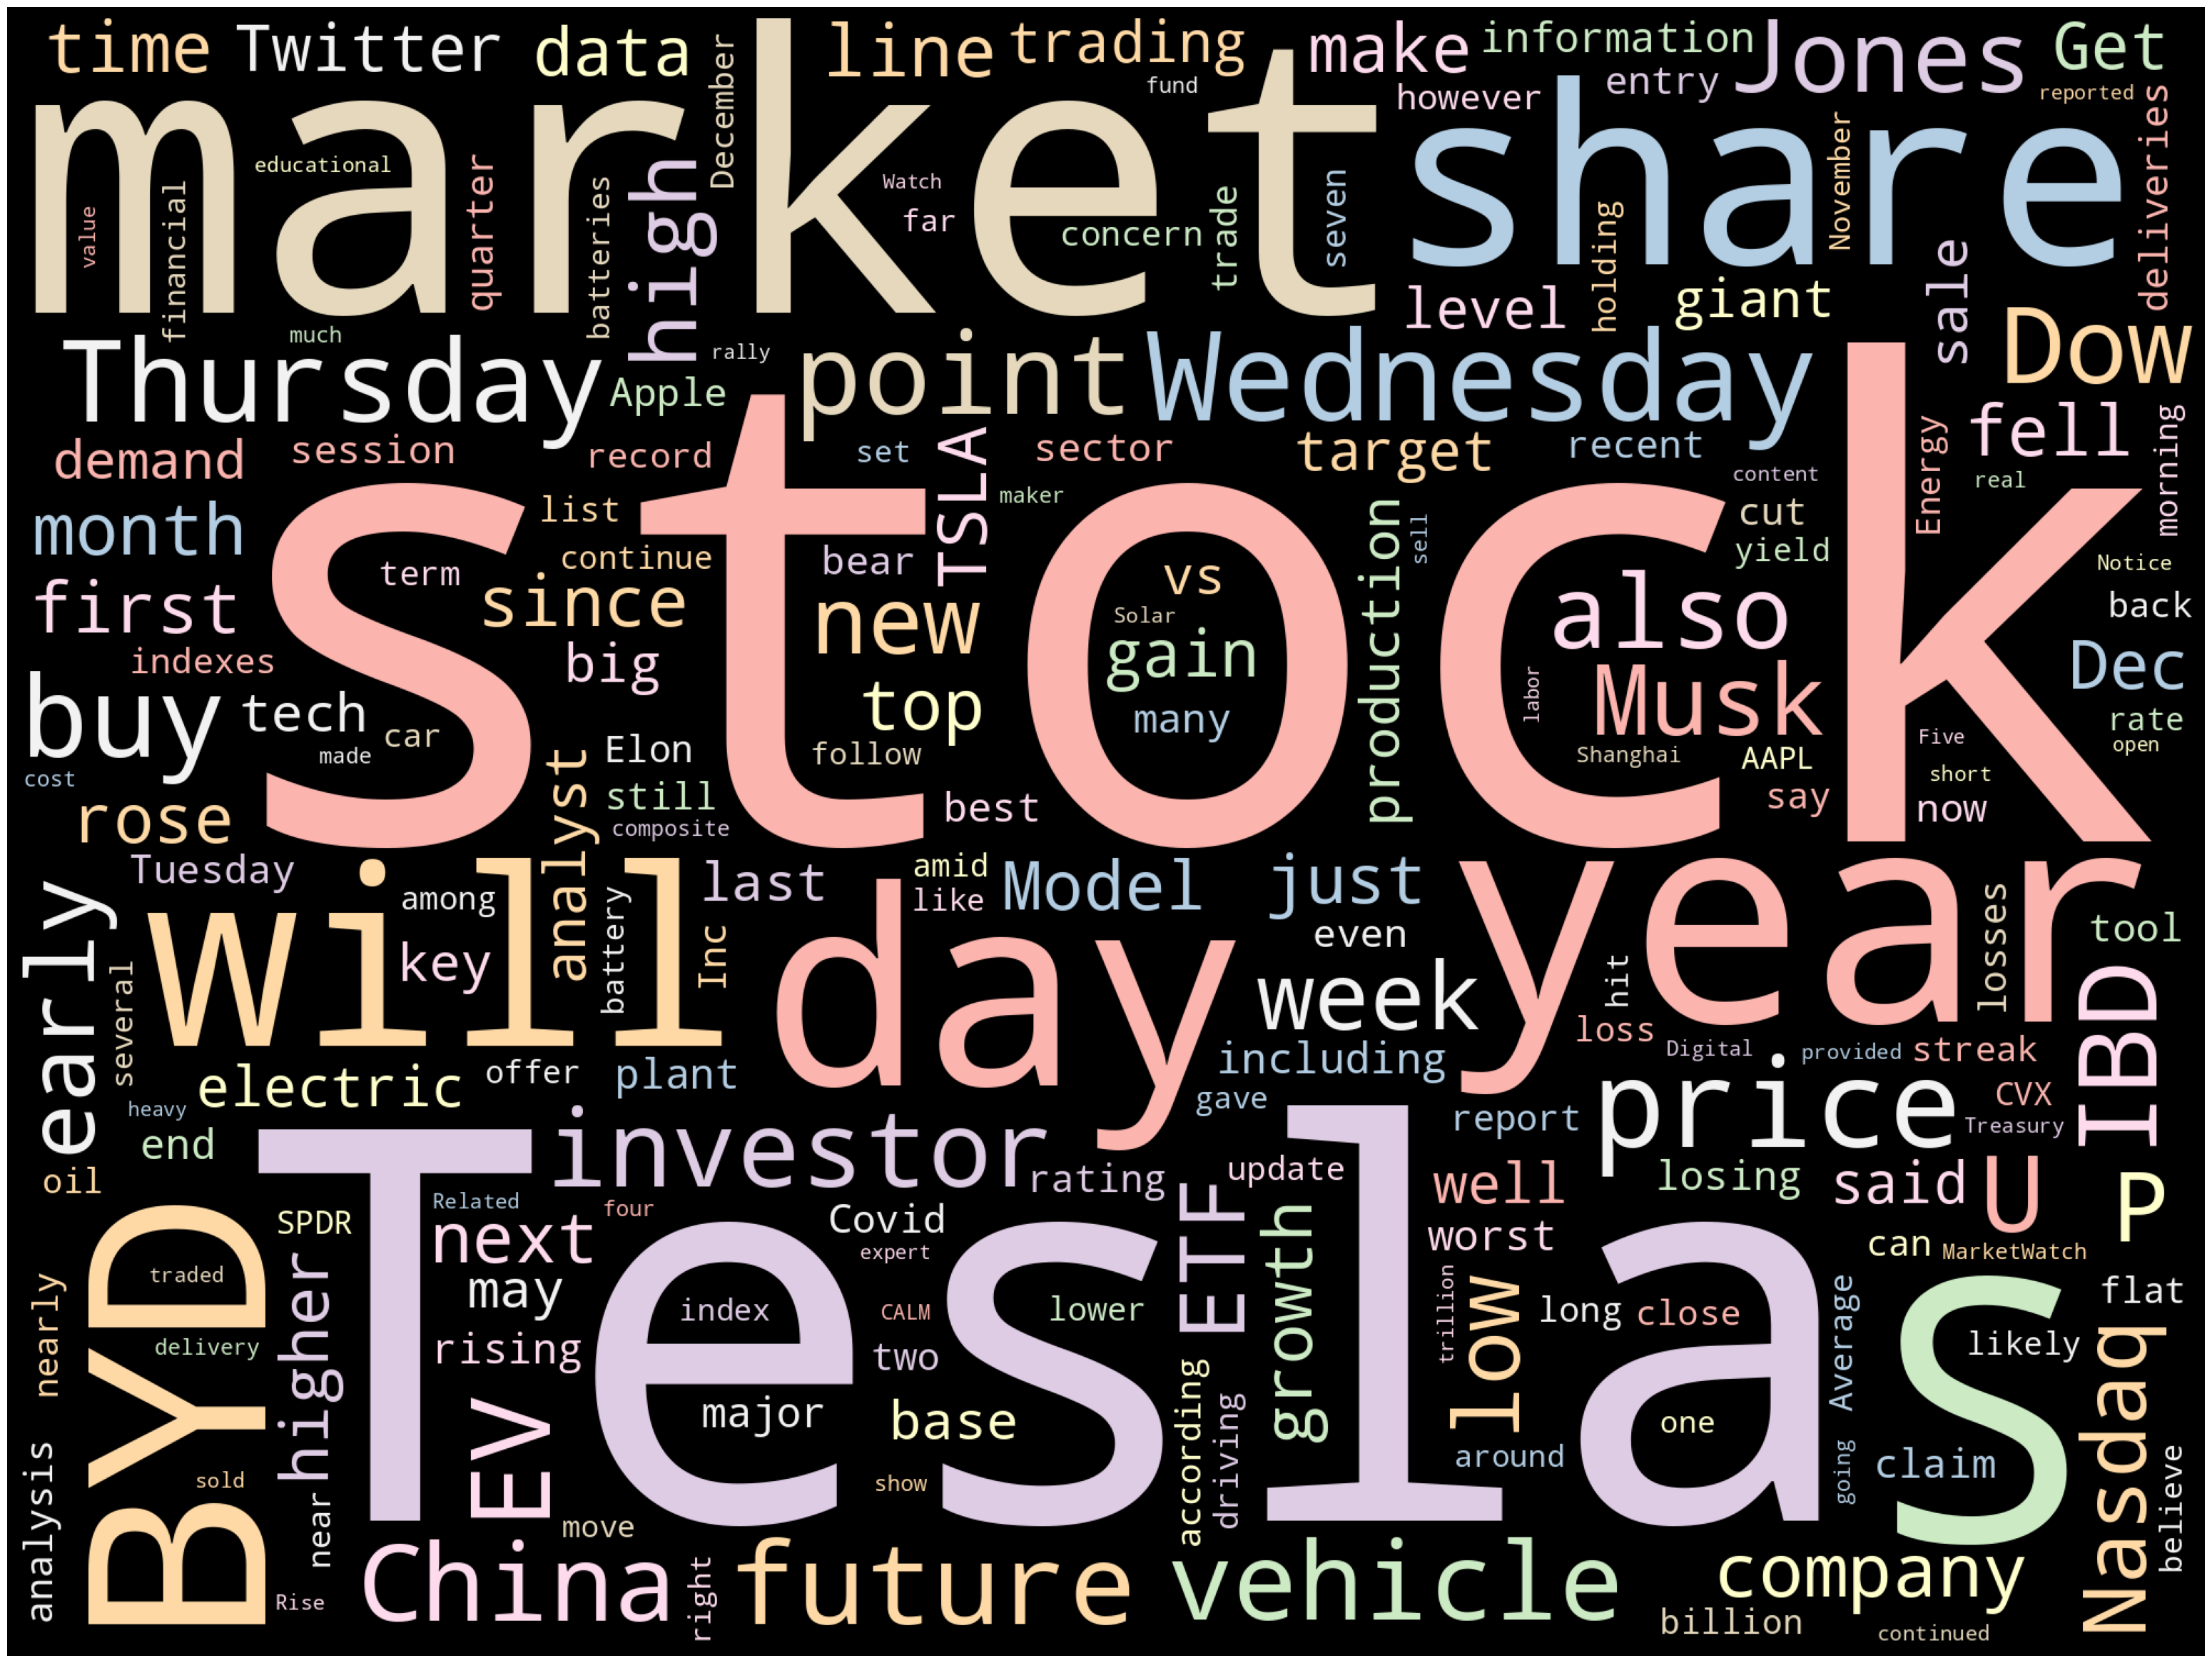

In [40]:
plot_cloud(wordcloud)

In [41]:
wordcloud.to_file('cloud.png')

# 4. Prediction model without news 

In [42]:
NUM_DAYS = 10000
INTERVAL = interval
symbol = ticker

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [43]:
df = pd.read_csv(ticker + '2.csv')
df.head()
# df.shape

,Date,Open,High,Low,Close,Adj Close,Volume
0,30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000
1,31/12/19,27.000000,28.086000,26.805332,27.888666,27.888666,154285500
2,02/01/20,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
3,03/01/20,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
4,06/01/20,29.364668,30.104000,29.333332,30.102667,30.102667,151995000


In [44]:
data = df

<AxesSubplot:>

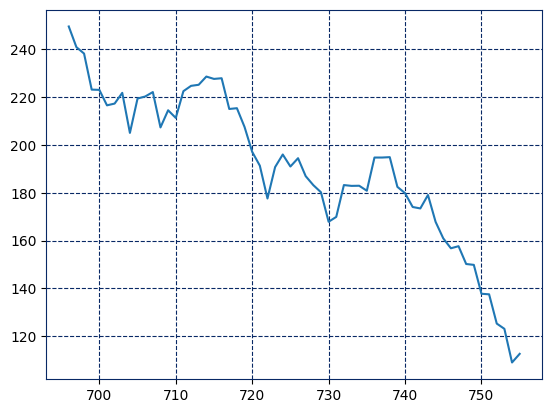

In [45]:
def _exponential_smooth(data, alpha):
    
    return df.ewm(alpha=alpha).mean()

df = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['Close'].plot()

In [46]:
def _get_indicator_data(data):

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(df)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

    data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

    del (data['Open'])
    del (data['High'])
    del (data['Low'])
    del (data['Volume'])
    del (data['Adj Close'])
    
    data = data.dropna(axis=1, how='all')
    
    return data

data = _get_indicator_data(data)


In [47]:
data.shape[0]

756

In [48]:
train_len = 6
test_len = 3

def get_trains(data, train_len):
    y_train = []
    x_train = []
    y_test = []
    x_test = []
    curr_state = 0
    
    while curr_state < data.shape[0]:
        
        df = data.iloc[curr_state:curr_state+train_len]
        targets = df['Close']
        del (df['Close'])
        features = df
        
        x_train, x_test, y_train, y_test = train_test_split(features, targets,
                                                           test_size=0.3)
        
        del x_train['Date']
#         del y_train['Date']

        curr_state += train_len 
    return x_train, x_test, y_train, y_test

In [49]:
X_train, X_test, y_train, y_test = get_trains(data, train_len)

In [50]:
live_pred_data = data.iloc[-16:-11]

def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
del (data['Date'])
data = data.dropna()
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
736,43.366690,-11.362416,-13.288239,71.046416,6.163970e+09,9.191565,-3.450153,53.308367,-1.671585,1.866430e+10,-23.967784,-0.017930,1.033345,0.968814,0.821352,0.926308,0.977337,1.049298,1.229029,0.0
737,46.139776,-9.925630,-12.615717,80.831262,6.184145e+09,8.915296,3.849446,62.481049,0.681450,1.875141e+10,22.532954,0.047132,0.961353,1.040608,0.824239,0.929421,0.978816,1.040747,0.916133,0.0
738,47.209661,-8.593956,-11.811365,84.591896,6.211541e+09,8.410494,8.945808,61.175416,0.384190,1.882970e+10,48.279751,0.040506,0.977152,1.052099,0.827758,0.933146,0.980953,1.034430,0.864415,0.0
739,41.385545,-8.063660,-11.061824,59.852539,6.176134e+09,8.380936,4.600029,52.996235,-1.398018,1.874177e+10,9.381379,-0.006071,0.996461,0.966002,0.778475,0.878761,0.923498,0.973654,1.077687,0.0
740,38.456915,-7.906504,-10.430760,49.771685,6.166998e+09,8.320281,9.377518,44.844639,-1.674889,1.865109e+10,-41.667921,-0.074441,1.077786,0.877880,0.770771,0.871398,0.915669,0.966121,1.054760,0.0


In [51]:
# y_train

In [52]:
def _train_random_forest(X_train, y_train, X_test, y_test):
    
    rf = RandomForestClassifier()
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    rf_gs.fit(X_train, y_train)
    rf_best = rf_gs.best_estimator_
        
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best

In [53]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    params_knn = {'n_neighbors': np.arange(1, 25)}
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    knn_gs.fit(X_train, y_train)
    knn_best = knn_gs.best_estimator_
    
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best

In [54]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):
    
    estimators=[('knn', knn_model), ('rf', rf_model)]
    ensemble = VotingClassifier(estimators, voting='hard')
    ensemble.fit(X_train, y_train)
    
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble

In [55]:
df = data

def cross_Validation(data):
    
    num_train = 10
    len_train = 40
    
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))
    
    
cross_Validation(data)

10 50
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12

[[10  0]
 [ 2  0]]
{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.50      0.67         2

    accuracy                           0.92        12
   macro avg       0.95      0.75      0.81        12
weighted avg       0.92      0.92      0.90        12

[[10  0]
 [ 1  1]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        10
         1.0       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42 

{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
en

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53         4
         1.0       1.00      0.12      0.22         8

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[4 0]
 [7 1]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53         4
         1.0       1.00      0.12      0.22         8

    accuracy                           0.42        12
   macro avg       0.68      0.56      0.38        12
weighted avg       0.79      0.42      0.33        12

[[4 0]
 [7 1]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.]
0.6666666666666666 0.4166666666666667 0.4166666

{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
en

{'n_estimators': 160}
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         3
         1.0       1.00      0.33      0.50         9

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 0]
 [6 3]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.33      0.67      0.44         3
         1.0       0.83      0.56      0.67         9

    accuracy                           0.58        12
   macro avg       0.58      0.61      0.56        12
weighted avg       0.71      0.58      0.61        12

[[2 1]
 [4 5]]
0.4166666666666667
              precision    recall  f1-score   support

         0.0       0.30      1.00      0.46         3
         1.0       1.00      0.22      0.36         9

    accuracy                           0.42        12
   macro avg       0.65      0.61     

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         9
         1.0       0.33      1.00      0.50         3

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 6]
 [0 3]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        12
weighted avg       0.06      0.25      0.10        12

[[0 9]
 [0 3]]
0.25
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.25      1.00      0.40         3

    accuracy                           0.25        12
   macro avg       0.12      0.50      0.20        1

{'n_estimators': 110}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
{'n_neighbors': 1}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
en

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.74        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12

[[7 5]
 [0 0]]
0.8333333333333334
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[10  2]
 [ 0  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
knn prediction is  [0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.75 0.5833333333333334 0.8333333333333334


{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
0.9166666666666666
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        11
         1.0       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12

[[11  0]
 [ 1  0]]
rf prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.9166666666666666 0.9166666666666666 0

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]
{'n_neighbors': 2}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      

{'n_neighbors': 5}
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         9
         1.0       0.33      1.00      0.50         3

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 6]
 [0 3]]
0.5
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.50         9
         1.0       0.33      1.00      0.50         3

    accuracy                           0.50        12
   macro avg       0.67      0.67      0.50        12
weighted avg       0.83      0.50      0.50        12

[[3 6]
 [0 3]]
rf prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
0.5 0.5 0.5
670 710
{'n_estimators': 110}
              precis

# 5. LSTM training model

In [56]:
dataset = []
maxStrokeLen = 0

with open("stock_data.csv") as f:
    reader = csv.reader(f)
    for row in reader:
            dataset.append(row[0].strip())
            
for i in dataset:
    if i:
        if len(i) > maxStrokeLen:
            maxStrokeLen = len(i)
        
maxStrokesCount = len(dataset) - 1
    
print(maxStrokeLen)
print(maxStrokesCount)

154
5791


In [57]:
maxWordLen = 15

positiveCount = 3685
negativeCount = 2106

tokenizer = Tokenizer(num_words=maxStrokesCount, lower=True, split=' ', char_level=False)
tokenizer.fit_on_texts(dataset)

dist = list(tokenizer.word_counts.items())


data = tokenizer.texts_to_sequences(dataset)
data_pad = pad_sequences(data, maxlen = maxWordLen)

X = data_pad
Y = np.array([[1,0]]*positiveCount + [[0,1]]*negativeCount)
print(X.shape, Y.shape)

(5792, 15) (5791, 2)


In [58]:
indeces = np.random.choice(X.shape[0]-1, size=X.shape[0]-1, replace=False)
X = X[indeces]
Y = Y[indeces]

In [60]:
model = Sequential()
model.add(Embedding(maxStrokesCount, 128, input_length = maxWordLen))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 128)           741248    
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 922,370
Trainable params: 922,370
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

In [62]:
history = model.fit(X, Y, batch_size=32, epochs=10)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

Epoch 1/10
181/181 [==============================] - 5s 16ms/step - loss: 0.6436 - accuracy: 0.6415
Epoch 2/10
181/181 [==============================] - 3s 15ms/step - loss: 0.5279 - accuracy: 0.7600
Epoch 3/10
181/181 [==============================] - 3s 15ms/step - loss: 0.4246 - accuracy: 0.8049
Epoch 4/10
181/181 [==============================] - 3s 15ms/step - loss: 0.3596 - accuracy: 0.8473
Epoch 5/10
181/181 [==============================] - 3s 15ms/step - loss: 0.3057 - accuracy: 0.8677
Epoch 6/10
181/181 [==============================] - 3s 15ms/step - loss: 0.2619 - accuracy: 0.8888
Epoch 7/10
181/181 [==============================] - 3s 15ms/step - loss: 0.2258 - accuracy: 0.9061
Epoch 8/10
181/181 [==============================] - 3s 15ms/step - loss: 0.1995 - accuracy: 0.9183
Epoch 9/10
181/181 [==============================] - 3s 15ms/step - loss: 0.1794 - accuracy: 0.9259
Epoch 10/10
181/181 [==============================] - 3s 15ms/step - loss: 0.1559 - accura

In [63]:
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [338]:
# t = "The oil brent is growing up! Economists predicts plus 5 precent to the cost".lower()
# data = tokenizer.texts_to_sequences([t])
# data_pad = pad_sequences(data, maxlen=maxWordLen)
# print( sequence_to_text(data[0]) )

# res = model.predict(data_pad)
# print(res, np.argmax(res), sep='\n')

# t1 = "Monday's relative weakness. NYX WIN TIE TAP ICE INT BMC AON C CHK BIIB  ".lower()
# data = tokenizer.texts_to_sequences([t1])
# data_pad = pad_sequences(data, maxlen=maxWordLen)
# print( sequence_to_text(data[0]) )

# res = model.predict(data_pad)
# print(res, np.argmax(res), sep='\n')

# t2 = "URALS brend is going higher and higher! Economysts forecasts a 10 precent growh in a week".lower()
# data = tokenizer.texts_to_sequences([t2])
# data_pad = pad_sequences(data, maxlen=maxWordLen)
# print( sequence_to_text(data[0]) )

# res = model.predict(data_pad)
# print(res, np.argmax(res), sep='\n')

In [337]:
# news_dates

In [79]:
df = pd.read_csv(ticker + '3.csv')

In [80]:
import random

sentiments = []
sent = [random.randint(0,1) for i in range(0, df.shape[0])]
med_mas = []

unique_dates = set()
for date in news_dates:
    curr_date, _ = date.split(' ')
    unique_dates.add(curr_date)
            
for dates in unique_dates:
    for article in articles:
        curr_date, _ = article.split(' || ')
        if dates in curr_date:
            data = tokenizer.texts_to_sequences([article])
            data_pad = pad_sequences(data, maxlen = maxWordLen)
            sentiments.append(np.argmax(model.predict(data_pad)))
            
    print(sentiments)
    med_val = round(sum(sentiments) / len(sentiments))
    print(med_val)
    med_mas.append(med_val)
    sentiments.clear()

1/1 [==============================] - 0s 16ms/step
[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
0
1/1 [==============================] - 0s 15ms/step
[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
0


In [81]:
del sent[-len(med_mas):]

for med in med_mas:
    sent.append(med)

In [82]:
print(med_mas == sent[-len(med_mas):])

True


In [83]:
len(sent)

756

# Predict model

In [77]:
df.shape

(756, 7)

In [85]:
df['sentiment'] = sent

In [86]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,1
1,31/12/19,27.000000,28.086000,26.805332,27.888666,27.888666,154285500,1
2,02/01/20,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,0
3,03/01/20,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,0
4,06/01/20,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,1


In [87]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'sentiment'],
      dtype='object')

In [88]:
# def _get_indicator_data(data):

#     for indicator in INDICATORS:
#         ind_data = eval('TA.' + indicator + '(df)')
#         if not isinstance(ind_data, pd.DataFrame):
#             ind_data = ind_data.to_frame()
#         data = data.merge(ind_data, left_index=True, right_index=True)
#     data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

#     data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
#     data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
#     data['ema15'] = data['Close'] / data['Close'].ewm(14).mean()
#     data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()

#     data['normVol'] = data['Volume'] / data['Volume'].ewm(5).mean()

# #     del (data['Open'])
# #     del (data['High'])
# #     del (data['Low'])
# #     del (data['Volume'])
    
#     data = data.dropna(axis=1, how='all')
    
#     return data

df = _get_indicator_data(df)

In [89]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment,14 period RSI,MACD,...,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
0,30/12/19,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,1,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,31/12/19,27.000000,28.086000,26.805332,27.888666,27.888666,154285500,1,100.0,0.005429,...,154285500.0,-66.666667,NaN,NaN,NaN,1.004314,1.004256,1.004207,1.003960,0.907711
2,02/01/20,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,0,100.0,0.031581,...,297267000.0,100.000000,NaN,NaN,NaN,1.021511,1.021173,1.020888,1.019447,0.897592
3,03/01/20,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,0,100.0,0.073391,...,563944500.0,122.716093,NaN,NaN,NaN,1.037943,1.037153,1.036488,1.033142,1.375606
4,06/01/20,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,1,100.0,0.117193,...,715939500.0,91.353032,NaN,NaN,NaN,1.045333,1.044060,1.042993,1.037700,0.834240


In [91]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [92]:
# df.columns

In [93]:
# for i in range(0, df.shape[0]):
#     if math.isnan(df['20 period CCI'][i]):
#         df['20 period CCI'][i] = 0

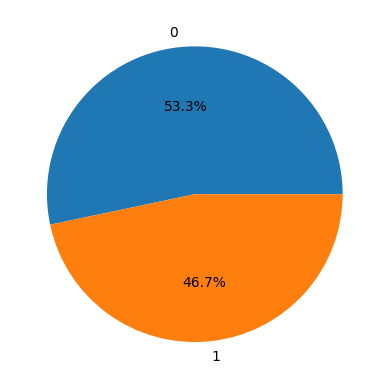

In [94]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

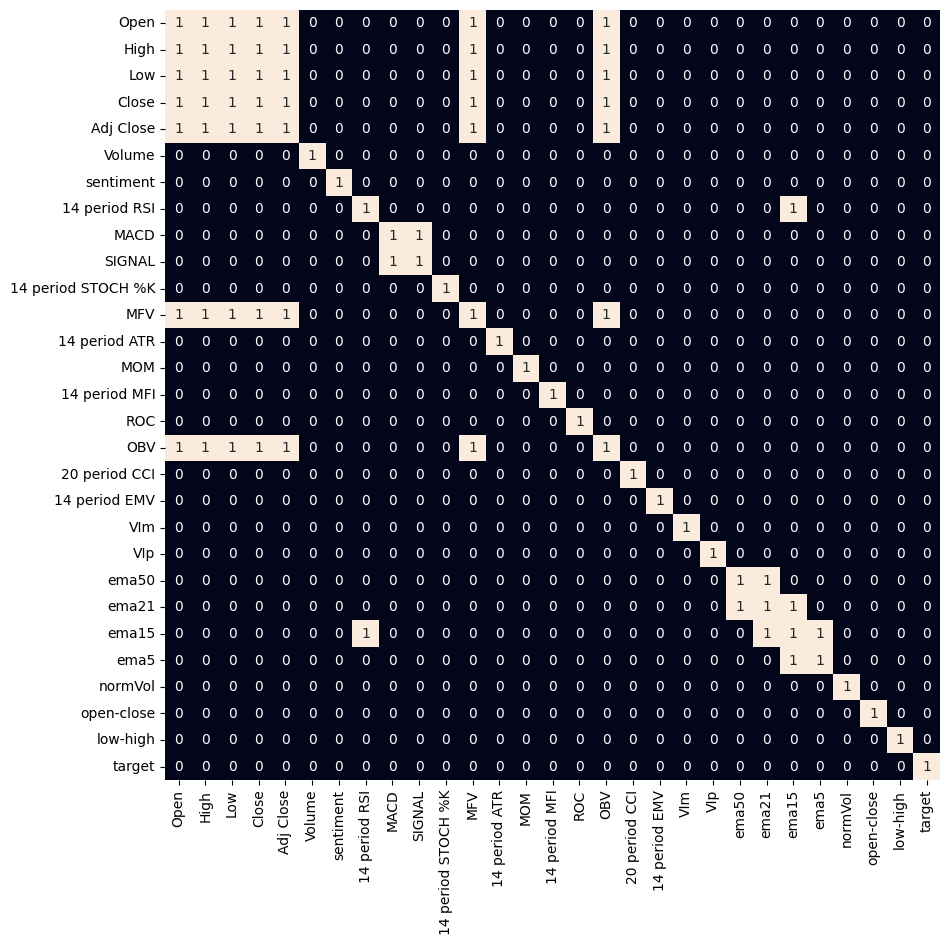

In [95]:
plt.figure(figsize=(10, 10))

sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [96]:
del df['Open']
del df['High']
del df['Low'] 

del df['MFV']
del df['OBV']

del df['14 period RSI']
del df['SIGNAL']

del df['ema50']
del df['ema21']

# del df['day']
# del df['month']
# del df['year']

KeyError: 'day'

In [98]:
del df['Adj Close']

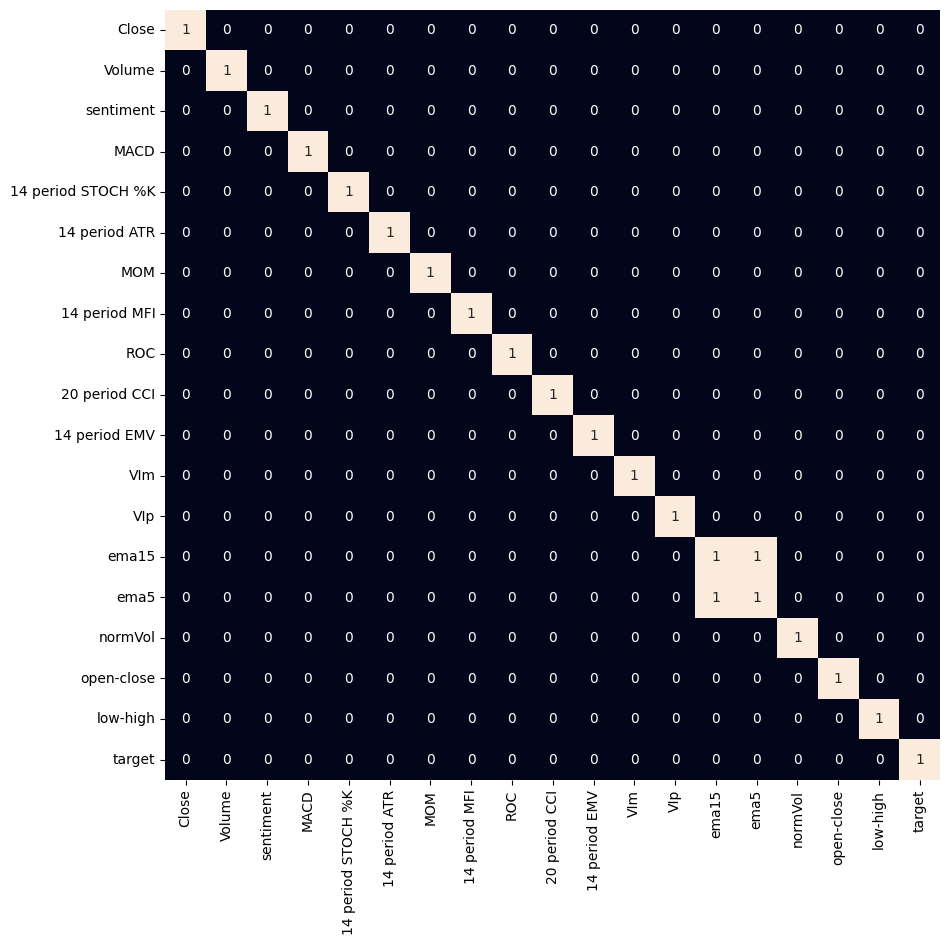

In [99]:
plt.figure(figsize=(10, 10))

sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [100]:
ind = list(df.columns)
ind.remove('target')
ind.remove('Date')
# ind.remove('day')
# ind.remove('month')
# ind.remove('year')

In [111]:
ind

['Close',
 'Volume',
 'sentiment',
 'MACD',
 '14 period STOCH %K',
 '14 period ATR',
 'MOM',
 '14 period MFI',
 'ROC',
 '20 period CCI',
 '14 period EMV',
 'VIm',
 'VIp',
 'ema15',
 'ema5',
 'normVol',
 'open-close',
 'low-high']

In [102]:
df.head()

,Date,Close,Volume,sentiment,MACD,14 period STOCH %K,14 period ATR,MOM,14 period MFI,ROC,20 period CCI,14 period EMV,VIm,VIp,ema15,ema5,normVol,open-close,low-high,target
0,30/12/19,27.646667,188796000,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.939333,-1.316000,1
1,31/12/19,27.888666,154285500,1,0.005429,NaN,NaN,NaN,NaN,NaN,-66.666667,NaN,NaN,NaN,1.004207,1.003960,0.907711,-0.888666,-1.280668,1
2,02/01/20,28.684000,142981500,0,0.031581,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,1.020888,1.019447,0.897592,-0.384001,-0.599333,1
3,03/01/20,29.534000,266677500,0,0.073391,NaN,NaN,NaN,NaN,NaN,122.716093,NaN,NaN,NaN,1.036488,1.033142,1.375606,-0.167334,-1.138666,1
4,06/01/20,30.102667,151995000,1,0.117193,NaN,NaN,NaN,NaN,NaN,91.353032,NaN,NaN,NaN,1.042993,1.037700,0.834240,-0.737999,-0.770668,1


In [103]:
# нужно почистить наны


# data = df.iloc[19:-19]
data = df.dropna()
features = data[ind]
# features = [x for x in df.columns if x not in ['target'] and x not in ['Date']]
target = data['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.10, random_state=2022)
print(X_train.shape, X_valid.shape)

(667, 18) (75, 18)


In [107]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()

LogisticRegression() : 
Training Accuracy :  0.6080421980562882
Validation Accuracy :  0.5391180654338549

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.7465316666064524
Validation Accuracy :  0.4907539118065434

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.490

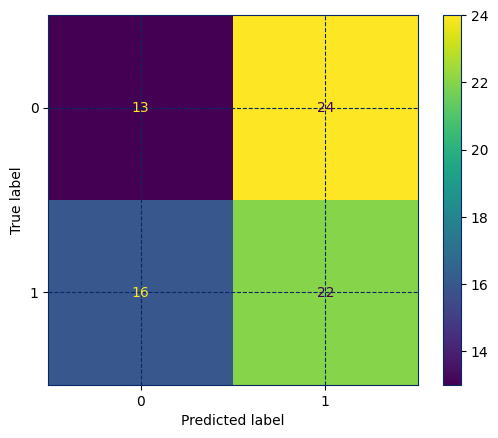

In [108]:
metrics.plot_confusion_matrix(models[2], X_valid, Y_valid)
plt.show()

In [112]:
del df['Date']

In [113]:
def cross_Validation(data):
    
    num_train = 10
    len_train = 40
    
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['target']
        features = [x for x in df.columns if x not in ['target']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)
        
        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)
        
        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)
        
        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)
        
        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)
        
        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)
        
        
    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))

cross_Validation(df)

10 50


ValueError: 
All the 35 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 331, in fit
    X, y = self._validate_data(
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1074, in check_X_y
    X = check_array(
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 899, in check_array
    _assert_all_finite(
  File "/home/shuller03/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
